<a href="https://colab.research.google.com/github/olusegunadelowo/Forecasting-Household-Electricity-Consumption-with-Time-Series-Model/blob/main/Time_Series_Analysis_Electricity_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# 2. Import Dataset

In [1]:
#Mounting the content of google drive (the content includes our dataset)
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
#importing the dataset from google drive
Energy_data = pd.read_csv("/content/gdrive/MyDrive/Data Science Projects/hamoyeInternship/Stage E - Time Series /household_power_consumption.csv",
                           sep=';', low_memory=False)

# 3. Data Wrangling

In [11]:
#Preview the 1st 7 rows of the table
Energy_data.head(7)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0


In [12]:
#Check shape of the data
Energy_data.shape

(2075259, 9)

## 3.1 Convert to datetime format YYYY-MM-DD HH:MM:SS

In [ ]:
#merge the date and time columns and form a new column called DateTime
Energy_data["DateTime"] = Energy_data["Date"] +" "+ Energy_data["Time"]
#delete Date and Time Columns
Energy_data.drop(Energy_data.iloc[:, 0:2], inplace=True, axis=1)
#convert DateTime column to datetime format YYYY-MM-DD HH:MM:SS
Energy_data["DateTime"] = pd.to_datetime(Energy_data["DateTime"])
#Convert DateTime column to index
Energy_data.set_index("DateTime", inplace=True)
#Preview the 1st 7 observations
Energy_data.head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
2006-12-16 17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
2006-12-16 17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0


## 3.2 Treat missing values and Change Columns' Datatypes

In [ ]:
#check for missing values
Energy_data.isnull().values.any()

True

`Observation` : There are missing values

In [ ]:
#Check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


`Observation` : On the CSV file, all columns protrayed as object/string are actually not.They are showing as object becuase of the presence of a string '?'

In [ ]:
#replace ? with 0
Energy_data = Energy_data.replace('?', 0)

In [ ]:
#check sum of missing data
Energy_data.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

`Observation` : Sub_metering_3 has missing values of 25979

In [ ]:
#Filling missing data by imputation - Forward fill
Energy_data = Energy_data.fillna(method='ffill')
Energy_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
#Convert all columns to float data types
Energy_data = Energy_data.astype(float)

In [ ]:
#Re-check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


Text(0,0.5,'Voltage')

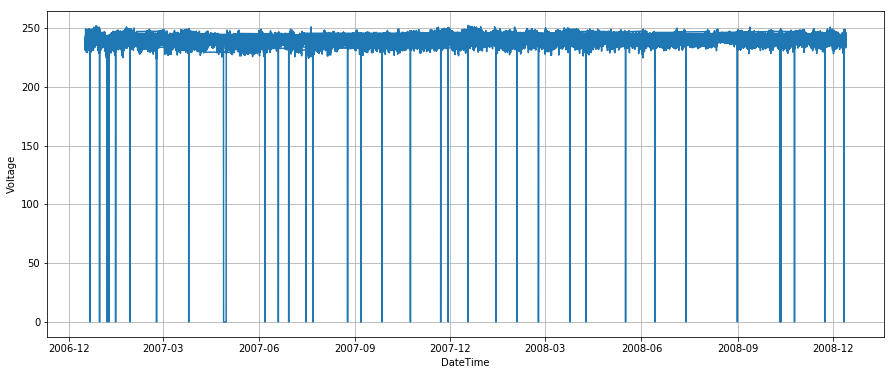

In [ ]:
#time-series plot of voltage reading against time
#plot voltage against datetime
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Voltage)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Voltage')

`Observation`: It's difficult to recognize patterns because our dataset has too many samples 1048576

## 3.3 Outliers detection and treatment

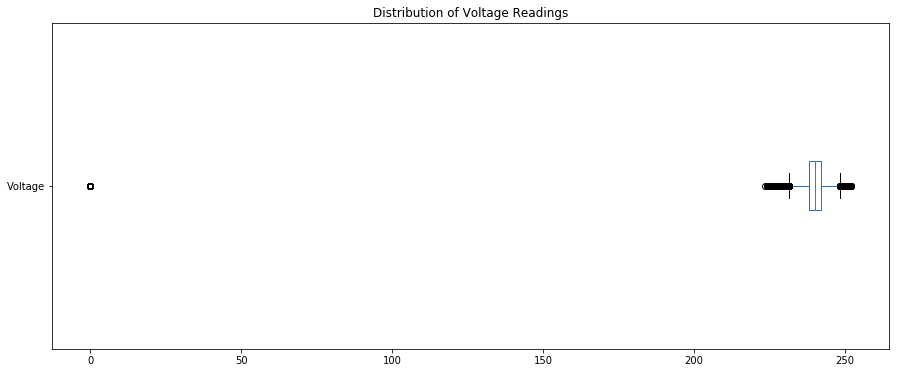

In [ ]:
#create a boxplot to detect the presence of outliers
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Voltage"].plot(kind="box" , vert = False, title = "Distribution of Voltage Readings" , ax = ax)

`Observations`: Our target variable "voltage" has a lot of outliers

In [ ]:
#Remove outlier
Energy_data = Energy_data[Energy_data["Voltage"] > 200]  #mask to remove outlier with value of Voltage greater than 200

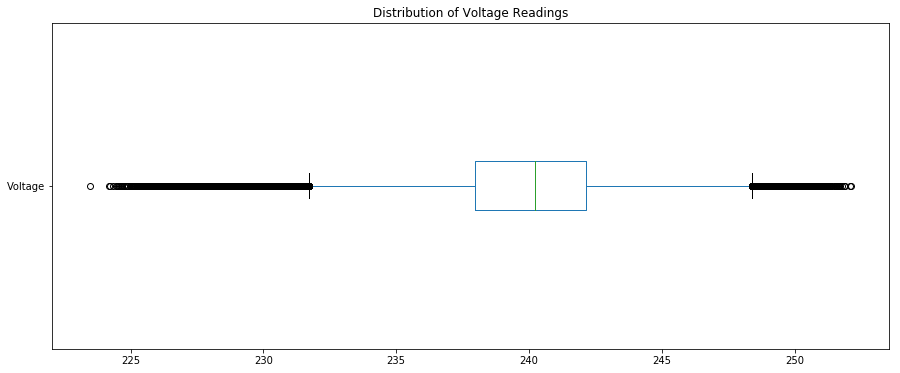

In [ ]:
#check if outliers have been removed
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Voltage"].plot(kind="box" , vert = False, title = "Distribution of Voltage Readings" , ax = ax)

Text(0,0.5,'Voltage')

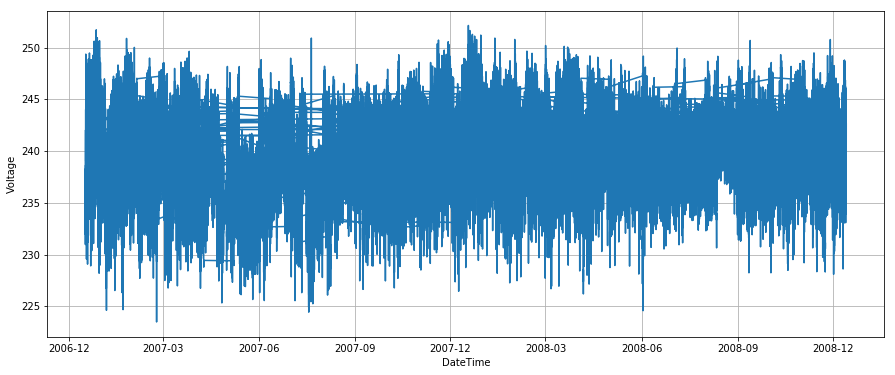

In [ ]:
#plot voltage against datetime after outlier removal
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Voltage)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Voltage')

`Observations`: The pattern became less congested with the removal of outliers

## 3.4 Resampling Target Variable

In [ ]:
#resampling(downsampling) for voltage readings to be 6months
Energy_data["Voltage"].resample("6M").mean().head(7)

DateTime
2006-12-31    241.441125
2007-06-30    239.142768
2007-12-31    239.617826
2008-06-30    240.442889
2008-12-31    240.551386
Name: Voltage, dtype: float64

In [ ]:
#Find out how many missing values
Energy_data["Voltage"].resample("6M").mean().isnull().sum()

0

In [ ]:
#Check that their's not missing value again
Energy_data["Voltage"].resample("6M").mean().fillna(method = "ffill").head().isnull().sum()

0

Text(0,0.5,'Voltage')

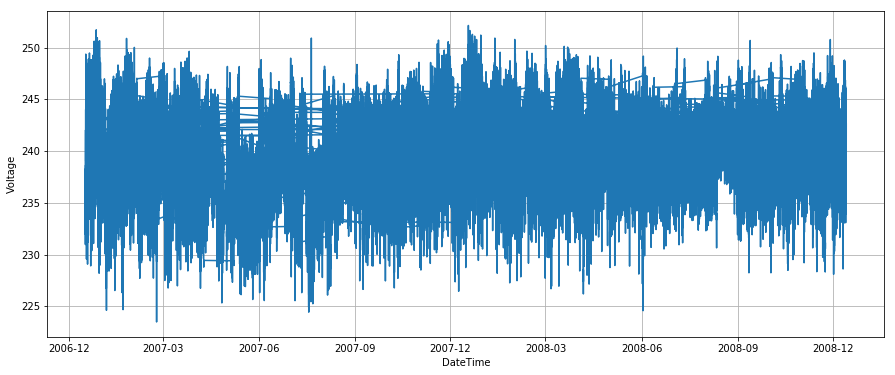

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Voltage)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Voltage')

`Observation`: The undersampling of target variable does not have any effect on the pattern.The pattern remained the same

## 3.5 Moving average smoothing

In [ ]:
#Rolling average to smoothen time-series data using 6 months interval.Smootheen graph enables to see hidden trend
Energy_data["Voltage"].rolling(4320).mean()

DateTime
2006-12-16 17:24:00           NaN
2006-12-16 17:25:00           NaN
2006-12-16 17:26:00           NaN
2006-12-16 17:27:00           NaN
2006-12-16 17:28:00           NaN
2006-12-16 17:29:00           NaN
2006-12-16 17:30:00           NaN
2006-12-16 17:31:00           NaN
2006-12-16 17:32:00           NaN
2006-12-16 17:33:00           NaN
2006-12-16 17:34:00           NaN
2006-12-16 17:35:00           NaN
2006-12-16 17:36:00           NaN
2006-12-16 17:37:00           NaN
2006-12-16 17:38:00           NaN
2006-12-16 17:39:00           NaN
2006-12-16 17:40:00           NaN
2006-12-16 17:41:00           NaN
2006-12-16 17:42:00           NaN
2006-12-16 17:43:00           NaN
2006-12-16 17:44:00           NaN
2006-12-16 17:45:00           NaN
2006-12-16 17:46:00           NaN
2006-12-16 17:47:00           NaN
2006-12-16 17:48:00           NaN
2006-12-16 17:49:00           NaN
2006-12-16 17:50:00           NaN
2006-12-16 17:51:00           NaN
2006-12-16 17:52:00           NaN
2006-

In [ ]:
#1st 4320h in the window has missing value
Energy_data["Voltage"].rolling(4320).mean().isnull().sum()

4319

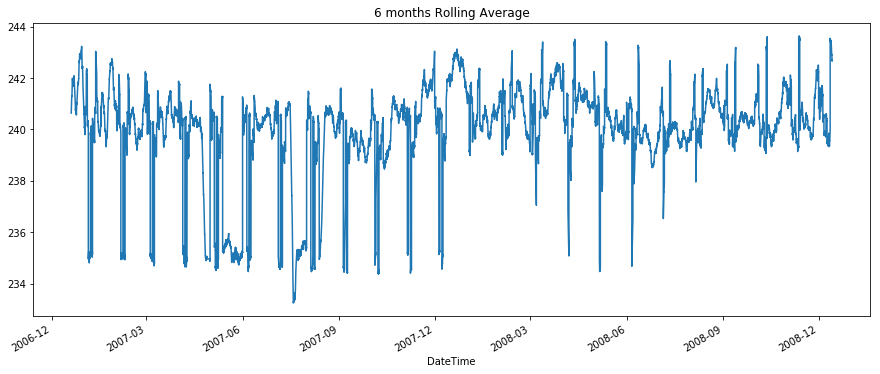

In [ ]:
#smoothens the pattern with 6 months rolling average
fig, ax = plt.subplots(figsize=(15, 6))
Energy_data["Voltage"].rolling(4320).mean().plot(ax=ax, label="Voltage" , title = "6 months Rolling Average");

# 4. Exploratory Data Analysis

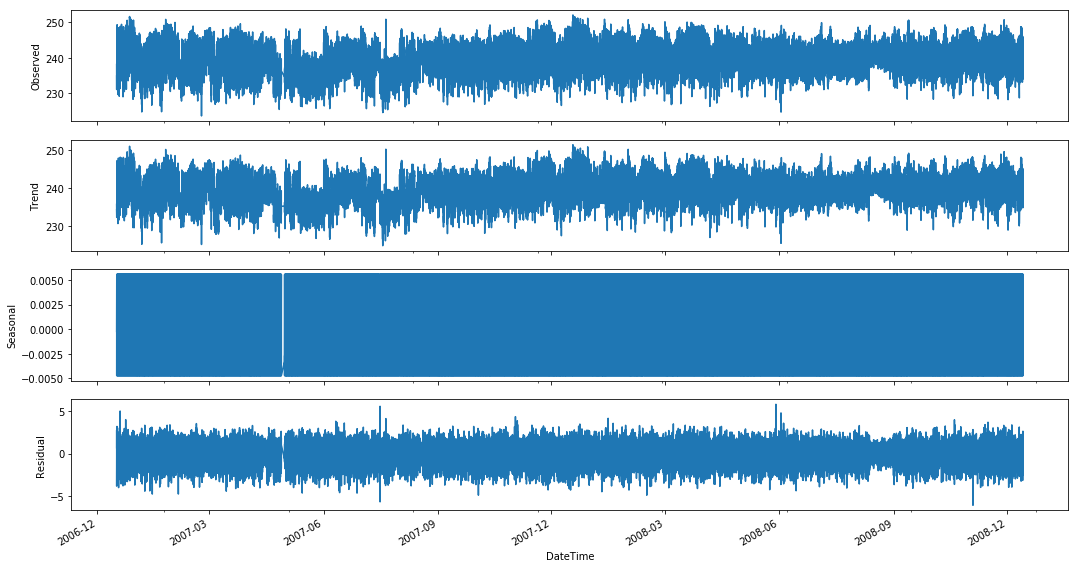

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(Energy_data['Voltage'], model='additive', freq=10)
decompose_series.plot()
plt.show()

In [ ]:
#performs an ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(Energy_data['Voltage'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}')

# 4 Feature Engineering

In [ ]:
# create a lag of the target variable Voltage
Energy_data["Voltage.L1"]= Energy_data["Voltage"].shift(1)
Energy_data.head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage.L1
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,NaN
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,234.84
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,233.63
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,233.29
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,233.74
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,235.68
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,235.02


In [ ]:
# Delete missing data Voltage.L1 column
Energy_data.dropna().head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage.L1
DateTime,,,,,,,,
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,234.84
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,233.63
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,233.29
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,233.74
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,235.68
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,235.02
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0,235.09


In [ ]:
#autocorrelation between target feature Voltage and predictor Voltage-L1
Energy_data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage.L1
Global_active_power,1.000000,0.254841,-0.400987,0.999020,0.474129,0.456677,0.624107,-0.389370
Global_reactive_power,0.254841,1.000000,-0.120617,0.271843,0.137682,0.150528,0.076274,-0.119251
Voltage,-0.400987,-0.120617,1.000000,-0.411298,-0.203805,-0.178899,-0.284932,0.982945
Global_intensity,0.999020,0.271843,-0.411298,1.000000,0.478198,0.462192,0.613220,-0.399443
Sub_metering_1,0.474129,0.137682,-0.203805,0.478198,1.000000,0.060830,0.115600,-0.194597
Sub_metering_2,0.456677,0.150528,-0.178899,0.462192,0.060830,1.000000,0.106461,-0.172511
Sub_metering_3,0.624107,0.076274,-0.284932,0.613220,0.115600,0.106461,1.000000,-0.284267
Voltage.L1,-0.389370,-0.119251,0.982945,-0.399443,-0.194597,-0.172511,-0.284267,1.000000


`Observation`: Target variable (Voltage) and its lag (Voltage.L1) has excellent positve correlation of 0.98

Text(0.5,1,'Voltage Autocorrelation')

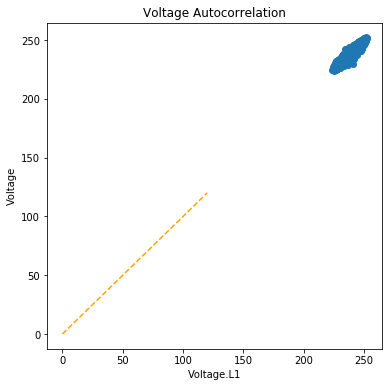

In [ ]:
#Plot of  Voltage and Voltage.L1
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=Energy_data["Voltage.L1"], y=Energy_data["Voltage"])
ax.plot([0,120], [0,120] , linestyle="--", color = "orange")
plt.xlabel("Voltage.L1")
plt.ylabel("Voltage")
plt.title("Voltage Autocorrelation")

# 5 Build Linear Regression Model

## 5.1 Split Data

In [ ]:
#List columns in the dataset
Energy_data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Voltage.L1'],
      dtype='object')

In [ ]:
#split data into x and y
y = Energy_data["Voltage"]   #target
X = Energy_data.drop(columns=['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'])   #predictor

In [ ]:
#cut-off splitting apllicable to time-series data
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

## 5.2 Baseline Model

In [ ]:
y_mean = y_train.mean()
y_pred_baseline =[y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean voltage Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean voltage Reading: 239.81
Baseline MAE: 2.71


## 5.3 Linear (Ridge) Regression Model

In [ ]:
#treating missing values in X_train
imputer = SimpleImputer()
imputer.fit(X_train)
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835604 entries, 0 to 835603
Data columns (total 1 columns):
Voltage.L1    835604 non-null float64
dtypes: float64(1)
memory usage: 6.4 MB


In [ ]:
#Instantiate an object of the class LinearRegression as model
model_reg = make_pipeline(SimpleImputer(), LinearRegression())
model_reg.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [ ]:
#Model predictions with ridge
y_pred_train_1 = model_reg.predict(X_train)
y_pred_test_1 = model_reg.predict(X_test)

In [ ]:
#Compare Model performance
training_mae = mean_absolute_error(y_pred_train_1 , y_train)
test_mae = mean_absolute_error(y_pred_test_1 , y_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.44
Test MAE: 0.38


## 5.4 Train Ridge Model

In [ ]:
#Model train with ridge
model_ridge = make_pipeline(SimpleImputer(), Ridge())
model_ridge.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [ ]:
#Model predictions with ridge
y_pred_train_2 = model_ridge.predict(X_train)
y_pred_test_2 = model_ridge.predict(X_test)

## 5.5 Ridge Performance Metric

In [ ]:
#Compare Model performance
training_mae = mean_absolute_error(y_pred_train_2 , y_train)
test_mae = mean_absolute_error(y_pred_test_2 , y_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.44
Test MAE: 0.38


`Observation`: The model generalizes well on an unseen data (test data).
               Both Linear Regression and Ridge have the same MAE of 0.38 with an unseen data

In [ ]:
df_pred_test = pd.DataFrame({"y_test":y_test ,"y_pred_test":model_reg.predict(X_test)})
df_pred_test.head(10)

,y_test,y_pred_test
DateTime,,
2008-07-21 17:53:00,239.55,239.485471
2008-07-21 17:54:00,239.63,239.554318
2008-07-21 17:55:00,239.41,239.633000
2008-07-21 17:56:00,239.45,239.416624
2008-07-21 17:57:00,239.46,239.455965
2008-07-21 17:58:00,239.48,239.465800
2008-07-21 17:59:00,240.16,239.485471
2008-07-21 18:00:00,239.76,240.154269
2008-07-21 18:01:00,239.97,239.760858
